# Section 1: Initial Setup and Data Loading¶

In [12]:
# Essential imports for our EDA
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from collections import Counter
from typing import Optional, List

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set style and color palette
sns.set_theme(style="darkgrid")
COLOR_PALETTE = sns.color_palette("viridis", n_colors=10)

print("📊 Starting Commodity Price Forecasting EDA")
print("=" * 50)

📊 Starting Commodity Price Forecasting EDA


## Memory Saving

In [ ]:
# ===================================================================================
# ✅ Complete Data Loading Cell for Mitsui Commodity Prediction Challenge
# ===================================================================================
import os
import pandas as pd
import numpy as np
import warnings

# Utility to list files for debugging
print("Available files under /kaggle/input/mitsui-commodity-prediction-challenge:")
print(os.listdir("/kaggle/input/mitsui-commodity-prediction-challenge"))

# Define paths
BASE = "/kaggle/input/mitsui-commodity-prediction-challenge"
TRAIN_CSV = f"{BASE}/train.csv"
TEST_CSV = f"{BASE}/test.csv"
LABELS_CSV = f"{BASE}/train_labels.csv"
PAIRS_CSV = f"{BASE}/target_pairs.csv"
LAGGED_DIR = f"{BASE}/lagged_test_labels"

# ================================================================================
# Memory optimization (NaN-safe)
def reduce_mem_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if df[col].isnull().all(): continue
        col_type = df[col].dtype
        c_min, c_max = df[col].min(skipna=True), df[col].max(skipna=True)
        if col_type != object and col_type.name != 'category':
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if not np.isnan(c_min) and not np.isnan(c_max):
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory downcast: {start_mem:.2f} → {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df

# # ================================================================================
# # Loading
# train = reduce_mem_usage(pd.read_csv(TRAIN_CSV), verbose=True)
# test = reduce_mem_usage(pd.read_csv(TEST_CSV), verbose=True)
# labels = reduce_mem_usage(pd.read_csv(LABELS_CSV), verbose=True)
# pairs = reduce_mem_usage(pd.read_csv(PAIRS_CSV), verbose=True)

# # Load all lagged test labels
# lagged = {}
# for fname in sorted(os.listdir(LAGGED_DIR)):
#     if fname.endswith(".csv"):
#         lag = fname.replace("test_labels_lag_", "").replace(".csv", "")
#         path = os.path.join(LAGGED_DIR, fname)
#         lagged[f"lag_{lag}"] = reduce_mem_usage(pd.read_csv(path), verbose=True)

# print("Loaded lagged test label files:", list(lagged.keys()))

# # ================================================================================
# # Confirm variables are defined
# print(f"train: {train.shape}, labels: {labels.shape}, pairs: {pairs.shape}")

## Without Memory saving
##### Saw weird behaviors when calculating mean, var
##### e.g.  train['LME_AH_Close'].var() comes out as inf

In [ ]:
# Define paths
BASE = "/kaggle/input/mitsui-commodity-prediction-challenge"
TRAIN_CSV = f"{BASE}/train.csv"
TEST_CSV = f"{BASE}/test.csv"
LABELS_CSV = f"{BASE}/train_labels.csv"
PAIRS_CSV = f"{BASE}/target_pairs.csv"
LAGGED_DIR = f"{BASE}/lagged_test_labels"

# ================================================================================
# Loading
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
labels = pd.read_csv(LABELS_CSV)
pairs = pd.read_csv(PAIRS_CSV)


# Generate Targets

In [48]:
def generate_log_returns(data: pd.Series, lag: int):
    log_returns = pd.Series(np.nan, index=data.index)

    # Compute log returns based on the rules
    for t in range(len(data)):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                log_returns.iloc[t] = np.log(data.iloc[t + lag + 1] / data.iloc[t + 1])
            except Exception:
                log_returns.iloc[t] = np.nan
    return log_returns

def generate_log_returns_dataframe(data: pd.DataFrame, lag: int):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        try:
            log_returns = np.log(data / data.shift(lag))
        except Exception:
            log_returns = data * np.nan
    return log_returns

def generate_targets(column_a: pd.Series, column_b: pd.Series, lag: int) -> pd.Series:
    a_returns = generate_log_returns(column_a, lag)
    b_returns = generate_log_returns(column_b, lag)
    return a_returns - b_returns

# generate_targets(train['LME_CA_Close'], train['US_Stock_CCJ_adj_close'], 4)

# EDA

In [ ]:
# Understanding the timeseries data

train_cols = [col.split("_")[0] for col in train.columns if col != 'date_id']

train_cols_counter = Counter(train_cols)

print("=" * 50)
print("\n# Instrument Categories:")
print("\n".join([f"{idx}. {item[0]}: {item[1]} instruments" for idx, item in enumerate(train_cols_counter.items())]))

print("\n\n", "="*50)
print("\n# Sample Instruments:")
for col_category in train_cols_counter:
    print(col_category, " :")
    print(" , ".join([col for col in train.columns if col.startswith(col_category)][:10]))

In [ ]:
def missing_value_analysis(df: pd.DataFrame, title):
    print(f"\n🔎 MISSING VALUE ANALYSIS: {title}")
    df_missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).apply(lambda x: "{:,.2f}%".format(x))
    display(df_missing.T)
    

def plot_feature_distributions(df: pd.DataFrame, cols: Optional[List[str]] = None,
                             n: int = 12, bins: int = 60, title: Optional[str] = None):
    if cols is None:
        # pick top features with max variance
        # Features with larger variances generally contain more information
        cols = df.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:n].tolist()

    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    ax = ax.flatten()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        for i, col in enumerate(cols):
            sns.histplot(df[col], bins=bins, kde=True, color=COLOR_PALETTE[i % len(COLOR_PALETTE)], ax=ax[i])

            # calculate median, skewness, kurtosis
            median = df[col].median()
            skewness = df[col].skew()
            kurtosis = df[col].kurt()
            
            ax[i].set_title(label=f"median={np.round(median,2)}, skew={np.round(skewness,2)}, kurt={np.round(kurtosis,2)}", fontsize=11)
            ax[i].grid(alpha=0.3)

        if title:
            plt.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_target_distributions(df: pd.DataFrame, n: int = 12, bins: int = 60):
    cols = [col for col in labels.columns if col.startswith("target_")][:n]
    plot_feature_distributions(df=df, cols=cols, n=n, title="Target Distributions of first 12 targets")

def plot_feature_correlation_matrix(df: pd.DataFrame, cols: Optional[List[str]] = None,
                                   n: int = 12, title: Optional[str] = None):
    if cols is None:
        # pick top features with max variance
        # Features with larger variances generally contain more information
        cols = df.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:n].tolist()

    corr = df[cols].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def plot_target_feature_correlation_matrix(train: pd.DataFrame, labels: pd.DataFrame, pairs: pd.DataFrame,
                                          n: int = 12, title: Optional[str] = None,
                                          correlation_threshold: float = 0.70,
                                          ax: plt.Axes = None):
    
    # Compute correlation
    df1 = train[[col for col in train.columns if col != 'date_id']] 
    
    # select label columns to run correlation on
    select_cols = []

    for lag in pairs['lag'].unique():
        targets = pairs[pairs['lag'] == lag]['target']
        random_cols = targets.iloc[(np.random.rand(10)*(len(targets)-1)).astype(int)].tolist()
        select_cols.extend(random_cols)

    select_cols = list(set(select_cols))
    select_pairs = pairs.set_index('target').loc[select_cols]['pair'] + "_lag_" + pairs.set_index('target').loc[select_cols]['lag'].astype(str)
    
    corr = pd.DataFrame(index = df1.columns, columns=select_pairs)
    
    for idx, col in enumerate(select_cols):
        corr.loc[df1.columns, select_pairs[idx]] = df1.corrwith(labels[col])

    high_correlation_data = corr[corr.abs() > correlation_threshold].replace(0, np.nan)
    high_correlation_data.dropna(how='all', axis=0, inplace=True)
    high_correlation_data.dropna(how='all', axis=1, inplace=True)

    if not(high_correlation_data.empty):
        # add an extra column or row if the len of any = 1
        if len(high_correlation_data.columns) == 1:
            high_correlation_data["dummy"] = 0
        if len(high_correlation_data.index) == 1:
            high_correlation_data.loc["dummy"] = 0

        high_correlation_data = high_correlation_data.astype(float)

        if ax is None:
            # Set up the matplotlib figure
            f, axes = plt.subplots(figsize=(11, 9))
    
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
                                     
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(high_correlation_data, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f",
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
        
        if ax is None:
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n❗no strong correlation found for the set threshold of {int(correlation_threshold*100)}%\n")

        if ax is None:
            # Set up the matplotlib figure
            f, ax = plt.subplots(figsize=(11,9))

        # stack correlation dataframe
        corr_stack = corr.stack()
        
        # Display the histogram of all correlations
        sns.histplot(corr_stack, kde=True, ax=ax)

        # calculate median, skewness, kurtosis
        median = corr_stack.median()
        skewness = corr_stack.skew()
        kurtosis = corr_stack.kurt()
        
        ax.set_title(label=f"median={np.round(median,2)}, skew={np.round(skewness,2)}, kurt={np.round(kurtosis,2)}", fontsize=11)
        ax.grid(alpha=0.3)
        
        if ax is None:
            plt.tight_layout()
            plt.show()

In [ ]:
missing_value_analysis(train, "TRAIN")
missing_value_analysis(test, "TEST")
missing_value_analysis(labels, "TRAIN_LABELS")

In [ ]:
print("\n# 🔎Distributions of train dataset with largest variances\n")
plot = plot_feature_distributions(train)

In [ ]:
print("\n# 🔎Distributions of train labels dataset with largest variances\n")
plot_target_distributions(labels)

In [ ]:
print("\n# 🔎Correlation Matrix of top 12 features by variance \n")
plot_feature_correlation_matrix(train)#, cols=['US_Stock_VYM_adj_close','LME_ZS_Close','US_Stock_VTV_adj_close'])

In [ ]:
print("\n# 🔎Correlation matrix for features with very high correlation\n")

def fetch_high_correlation_columns(df: pd.DataFrame, correlation_threshold: float):
    correlation_data = train.corr()
    
    high_corelation_columns = []

    # loop through correlation matrix to fetch the high correlation columns
    for i in range(len(correlation_data.columns)-1):
        for j in range(i+1, len(correlation_data.columns)):
            coli = correlation_data.columns[i]
            colj = correlation_data.columns[j]
            if (np.abs(correlation_data.loc[coli, colj]) > correlation_threshold):
                high_corelation_columns.extend([coli, colj])
    
    high_corelation_columns = list(set(high_corelation_columns))

    return high_corelation_columns

cols = fetch_high_correlation_columns(train, 0.99)

plot_feature_correlation_matrix(train, cols=cols[:20])

In [ ]:
%%time
print(f"\n# 🔎Target - Feature correlation matrix with a correlation threshold: {correlation_threshold}\n")

plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.2)

In [ ]:
%%time
print("\n🔎 Checking if taking log returns have any impact on the correlation distribution")

f, ax = plt.subplots(2,3, figsize=(11, 9))

log_returns = generate_log_returns_dataframe(train, 1)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][0])

log_returns = generate_log_returns_dataframe(train, 4)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][1])

log_returns = generate_log_returns_dataframe(train, 10)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][2])

log_returns = generate_log_returns_dataframe(train, 20)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[1][0])

log_returns = generate_log_returns_dataframe(train, 30)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[1][1])

plt.tight_layout()
plt.show()

# Feature Engineering

In [1]:
# Specific imports for this section

import networkx as nx

In [55]:
def date_features(df):
    df['dayofweek'] = df['date_id'] % 7
    df['month'] = (df['date_id'] // 30) % 12
    df['quarter'] = df['month'] // 3
    df['day_of_month'] = df['date_id'] % 30

    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['day_of_month'] == 0).astype(int)
    df['is_month_end'] = (df['day_of_month'] == 29).astype(int)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

def dispersion_of_correlated_instruments(df: pd.DataFrame, correlation_threshold: int):
    corr = train[[col for col in train.columns if col != 'date_id']].corr()

    # Construct a Graph with columns pairs as edges for pairs with high correlation
    G = nx.Graph()
    for i in corr.columns:
        for j in corr.columns:
            if i != j and np.abs(corr.loc[i, j]) > correlation_threshold:
                G.add_edge(i, j)
    
    # Get connected components (each is a cohort)
    cohorts = list(nx.connected_components(G))    
    print(f"\n🌐 Number of cohorts founds: {len(cohorts)}\n")

    # Generate std, skew and kurtosis for each of those cohorts on a daily basis (axis=1)
    dispersion_dict = {}
    for idx, cohort in enumerate(cohorts):
        group = train[list(cohort)]
        dispersion_dict[f'Cohort_{idx}'] = pd.DataFrame({
            'std': group.std(axis=1),
            'skew': group.skew(axis=1),
            'kurtosis': group.kurt(axis=1)  # or .kurtosis(axis=1)
        })

    return dispersion_dict

def add_dispersion_features(df: pd.DataFrame, correlation_threshold: int):
    dispersion_dict = dispersion_of_correlated_instruments(df, correlation_threshold)
    features = []
    for cohort in dispersion_dict:
        old_columns = df.columns
        new_features = [f'{cohort}_std',f'{cohort}_skew',f'{cohort}_kurt']
        features.extend(new_features)
        new_columns = list(old_columns) + [f'{cohort}_std',f'{cohort}_skew',f'{cohort}_kurt']
        df = pd.concat([df, dispersion_dict[cohort]], axis=1)
        df.columns = new_columns
    return df, features

def add_log_return_features(df: pd.DataFrame, lag: int = 1, columns: list = None):
    if columns is None:
        columns = [x for x in df.columns if x != 'date_id']
    log_returns = np.log(df[columns] / df[columns].shift(lag))
    features = [f'{x}_{lag}_log_ret' for x in columns]
    log_returns.columns = features
    return log_returns, features

def add_target_log_return_features(df: pd.DataFrame, pairs_df: pd.DataFrame, lag: int = 1):
    pairs_df_unique = pairs_df.copy()
    pairs_df_unique.drop(columns=['lag'], inplace=True)
    pairs_df_unique.drop_duplicates(inplace=True)
    features = []
    result_df = []
    for idx in pairs_df_unique.index:
        target = pairs_df_unique.loc[idx, 'target']
        pair = pairs_df_unique.loc[idx, 'pair']
        pairs = pair.split(" - ")
        log_returns, _ = add_log_return_features(df, lag, pairs)
        if len(pairs) == 1:
            log_returns_diff = log_returns.iloc[:, 0]
        elif len(pairs) == 2:
            log_returns_diff = log_returns.iloc[:, 0] - log_returns.iloc[:, 1]
        else:
            continue
        result_df.append(log_returns_diff)
        features.append(f'{target}_{lag}_log_ret_diff')
    result_df = pd.concat(result_df, axis=1)
    result_df.columns = features
    return result_df, features

In [ ]:
def plot_dispersion_dict(dispersion_dict):
    fig, ax = plt.subplots(figsize=(11,9))
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(dispersion_dict)))
    for i, (cohort, df) in enumerate(dispersion_dict.items()):
        if i == 0:
            df['std'].plot(ax=ax, label=cohort, color=colors[i])
        else:
            ax_i = ax.twinx()
            df['std'].plot(ax=ax_i, label=cohort, color=colors[i])
                    
            # Hide extra y-axis
            ax_i.get_yaxis().set_visible(False)
            ax_i.spines["right"].set_visible(False)
    
    # Show only one legend
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left')
    
    # plt.legend()
    plt.tight_layout()
    plt.title("Daily Standard Deviation per Cohort")
    plt.show()

In [ ]:
print(f"\n🌐 Analysing dispersion of correlated instruments\n")

dispersion_dict = dispersion_of_correlated_instruments(train, 0.95)
plot_dispersion_dict(dispersion_dict)

In [ ]:
print(f"\n🌐 Target - feature analysis of dispersion (std) of cohort_0 with all targets\n")

index = dispersion_dict['Cohort_0']['std'].index

dispersion_df_std = pd.DataFrame([df['std'] for cohort, df in dispersion_dict.items()], index=dispersion_dict.keys(), columns=index).transpose()

plot_target_feature_correlation_matrix(dispersion_df_std, labels, pairs, correlation_threshold=0.5)

# Training

In [3]:
# specific imports for training

# Utility imports
import os, gc, warnings, random, pickle
from pathlib import Path

# Booster imports
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import HistGradientBoostingRegressor

# Validation imports
from sklearn.model_selection import KFold

# data imports
import numpy as np
import pandas as pd
import polars as pl

from tqdm.auto import tqdm
import torch
import kaggle_evaluation.mitsui_inference_server

In [5]:
# ====================================================
# Config
# ====================================================
class Config:
    AUTHOR = 'mitsui_ai'
    VERSION = 2
    SEED = 42
    N_FOLDS = 3
    BOOSTERS = ['lgbm', 'xgb', 'cat']
    MAX_ROUNDS = 2500
    EARLY_STOP = 100
    VERBOSE = 1
    DATA_DIR = Path('/kaggle/input/mitsui-commodity-prediction-challenge')
    MODEL_DIR = Path('./models'); os.makedirs(MODEL_DIR, exist_ok=True)
    OOF_DIR = Path('./oof'); os.makedirs(OOF_DIR, exist_ok=True)
    TARGET_COUNT = 424
    FEATURES_TO_ADD = ['target_id']

    LGBM_PARAMS = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.005, 'num_leaves': 8, 'seed': SEED,
        'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0,
    }

    XGB_PARAMS = {
        'objective': 'reg:squarederror', 'eval_metric': 'rmse',
        'learning_rate': 0.005, 'max_depth': 4, 'random_state': SEED,
        'tree_method': "hist", 'device': "cuda"
        # 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor',
    }

    CAT_PARAMS = {
        'loss_function': 'RMSE', 'learning_rate': 0.005,
        'iterations': MAX_ROUNDS, 'depth': 4,
        'random_seed': SEED, 'verbose': False,
        'task_type': 'GPU', 'devices': '0:1',
    }
    
    HGB_PARAMS = {
        "max_iter": MAX_ROUNDS,
        "random_state": SEED,
        "early_stopping": True,  # Stops early if no improvement
        "n_iter_no_change": EARLY_STOP,  # Speed up convergence
    }
    

In [6]:

# ====================================================
# Seed and Utility
# ====================================================
def set_seed(seed=Config.SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# ====================================================
# Train Booster
# ====================================================
def train_model(booster, x_tr, y_tr, x_val, y_val):
    # Handle missing values
    y_tr = np.nan_to_num(y_tr, nan=0.0)
    y_val = np.nan_to_num(y_val, nan=0.0)

    if booster=="lgbm":
        train_set = lgb.Dataset(x_tr, y_tr)
        val_set = lgb.Dataset(x_val, y_val)
        model = lgb.train(
            Config.LGBM_PARAMS, train_set,
            num_boost_round=Config.MAX_ROUNDS,
            valid_sets=[val_set],
            callbacks=[
                lgb.early_stopping(Config.EARLY_STOP),
                lgb.log_evaluation(Config.VERBOSE)
            ]
        )
        return model, model.predict(x_val)
    
    elif booster=='xgb':
        train_d = xgb.DMatrix(x_tr, label=y_tr)
        valid_d = xgb.DMatrix(x_val, label=y_val)
        model = xgb.train(
            Config.XGB_PARAMS, train_d,
            num_boost_round=Config.MAX_ROUNDS,
            evals=[(valid_d, 'eval')],
            early_stopping_rounds=Config.EARLY_STOP,
            verbose_eval=Config.VERBOSE
        )
        return model, model.predict(xgb.DMatrix(x_val))

    elif booster=='cat':
        train_pool = Pool(x_tr, label=y_tr)
        valid_pool = Pool(x_val, label=y_val)
        model = CatBoostRegressor(**Config.CAT_PARAMS)
        model.fit(train_pool, eval_set=valid_pool,
                  early_stopping_rounds=Config.EARLY_STOP)
        return model, model.predict(x_val)

    elif booster=='histgb':
        model = HistGradientBoostingRegressor(**Config.HGB_PARAMS)
        model.fit(x_tr , y_tr)
        return model, model.predict(y_val)

# ====================================================
# Training CV Wrapper
# ====================================================
def run_cv(booster, df, features):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['target'], inplace=True)

    oof_preds = np.zeros(len(df))
    kf = KFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        x_tr = df.iloc[train_idx][features]
        y_tr = df.iloc[train_idx]['target']
        x_val = df.iloc[val_idx][features]
        y_val = df.iloc[val_idx]['target']

        model, val_preds = train_model(booster, x_tr, y_tr, x_val, y_val)
        oof_preds[val_idx] = val_preds

        with open(Config.MODEL_DIR / f'{booster}_fold{fold}.pkl', 'wb') as f:
            pickle.dump(model, f)

        del model, x_tr, y_tr, x_val, y_val
        gc.collect()

    np.save(Config.OOF_DIR / f'oof_{booster}.npy', oof_preds)
            

In [ ]:
%%time
# ====================================================
# Load Data
# ====================================================
train_df = pl.read_csv(Config.DATA_DIR / 'train.csv').to_pandas()
label_df = pl.read_csv(Config.DATA_DIR / 'train_labels.csv').to_pandas()
pairs_df = pl.read_csv(Config.DATA_DIR / 'target_pairs.csv').to_pandas()

features = list(train_df.columns[1:]) + Config.FEATURES_TO_ADD

def prepare_data(X: pd.DataFrame, Y: pd.DataFrame=None, testing: bool = False):
    X_df = X.copy()
    for col in X_df.columns:
        if X_df[col].dtype == 'object':
            X_df[col] = np.nan

    # date features
    X_df = date_features(X_df)

    # target log return features
    log_returns_diff, lag_1_log_return_diff_features = add_target_log_return_features(X_df, pairs_df, lag=1)
    X_df = pd.concat([X_df, log_returns_diff], axis=1)

    X_df_all = []
    for tid in range(Config.TARGET_COUNT if testing else len(Y.columns[1:])):
        temp = X_df.copy()
        if Y is not None:
            temp['target'] = Y.iloc[:, tid+1]
            temp = temp.dropna(subset=['target'])
        temp['target_id'] = tid
        X_df_all.append(temp)

    X_df = pd.concat(X_df_all, axis=0).reset_index(drop=True)
    features_final = features + [
        'dayofweek', 'month', 'quarter', 'day_of_month',
        'is_weekend', 'is_month_start', 'is_month_end'
        ] + lag_1_log_return_diff_features
    
    if testing:
        ret_X_df = X_df[features_final]
    else:
        ret_X_df = X_df
        
    if Y is not None:
        ret_Y_S = X_df['target']
        return ret_X_df, features_final, ret_Y_S
    else:
        return ret_X_df, features_final, 0

# df_all = []
# for j, col in enumerate(label_df.columns[1:]):
#     temp = train_df.copy()
#     temp['target'] = label_df[col]
#     temp['target_id'] = j
#     temp = add_features(temp)
#     temp = temp.dropna(subset=['target'])
#     df_all.append(temp)

# train_full = pd.concat(df_all, axis=0).reset_index(drop=True)
train_full, features_final, Y_full = prepare_data(train_df, label_df, testing=False)

In [8]:
%%time
# ====================================================
# base line RMSE
# ====================================================
print(f"Target for RMSE to be lower than: ", Y_full.std())

# ====================================================
# Train All Boosters
# ====================================================
for booster in Config.BOOSTERS:
    print(f"\n[Training {booster.upper()}]")
    run_cv(booster, train_full, features_final)

Target for RMSE to be lower than:  0.031759824462223675

[Training LGBM]
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 142271
[LightGBM] [Info] Number of data points in the train set: 484606, number of used features: 565
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 557 dense feature groups (258.81 MB) transferred to GPU in 0.158176 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.000049
[1]	valid_0's rmse: 0.0318764
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.0318765
[3]	valid_0's rmse: 0.0318766
[4]	valid_0's rmse: 0.0318766
[5]	valid_0's rmse: 0.0318767
[6]	valid_0's rmse: 0.0318767
[7]	valid_0's rmse: 0.0318768
[8]	valid

# Understanding the trained models

In [43]:
def model_analysis(target: pd.Series, predictions: pd.Series, model_name: str = ""):
    f, ax = plt.subplots(2,2,figsize=(11,9))
    
    # Distribution of actual target values
    sns.histplot(target.to_list(), kde=True, ax=ax[0][0])
    ax[0][0].set_title('Target Distribution')
    
    ## Distribution of OOF predictions (takes too long)
    # sns.histplot(predictions, kde=False, ax=ax[0][1])
    
    ax[0][1].hist(predictions, bins=100, alpha=0.7, density=True)
    ax[0][1].set_title(f'{model_name} OOF Predictions Distribution')
    
    # Scatter plot: Actual vs Predicted
    ax[1][0].scatter(target, predictions, alpha=0.6)
    ax[1][0].set_xlabel('Actual Target')
    ax[1][0].set_ylabel(f'{model_name} OOF Predictions')
    ax[1][0].plot([target.min(), target.max()], [target.min(), target.max()], 'r--', alpha=0.8)
    ax[1][0].set_title('Actual vs Predicted')
    
    # Residuals plot
    residuals = target - predictions
    ax[1][1].scatter(predictions, residuals, alpha=0.6)
    ax[1][1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    ax[1][1].set_xlabel(f'{model_name} OOF Predictions')
    ax[1][1].set_ylabel('Residuals')
    ax[1][1].set_title('Residuals Plot')
    
    # Overall title
    f.suptitle(f'{model_name} Model Analysis', fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np
    
    mse = mean_squared_error(target, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(target, predictions)
    r2 = r2_score(target, predictions)
    
    print(f"\n{model_name} OOF Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

In [41]:
oof_cat = pd.Series(np.load(Config.OOF_DIR / "oof_cat.npy"), dtype='float64')
oof_lgbm = pd.Series(np.load(Config.OOF_DIR / "oof_lgbm.npy"), dtype='float64')
oof_xgb = pd.Series(np.load(Config.OOF_DIR / "oof_xgb.npy"), dtype='float64')

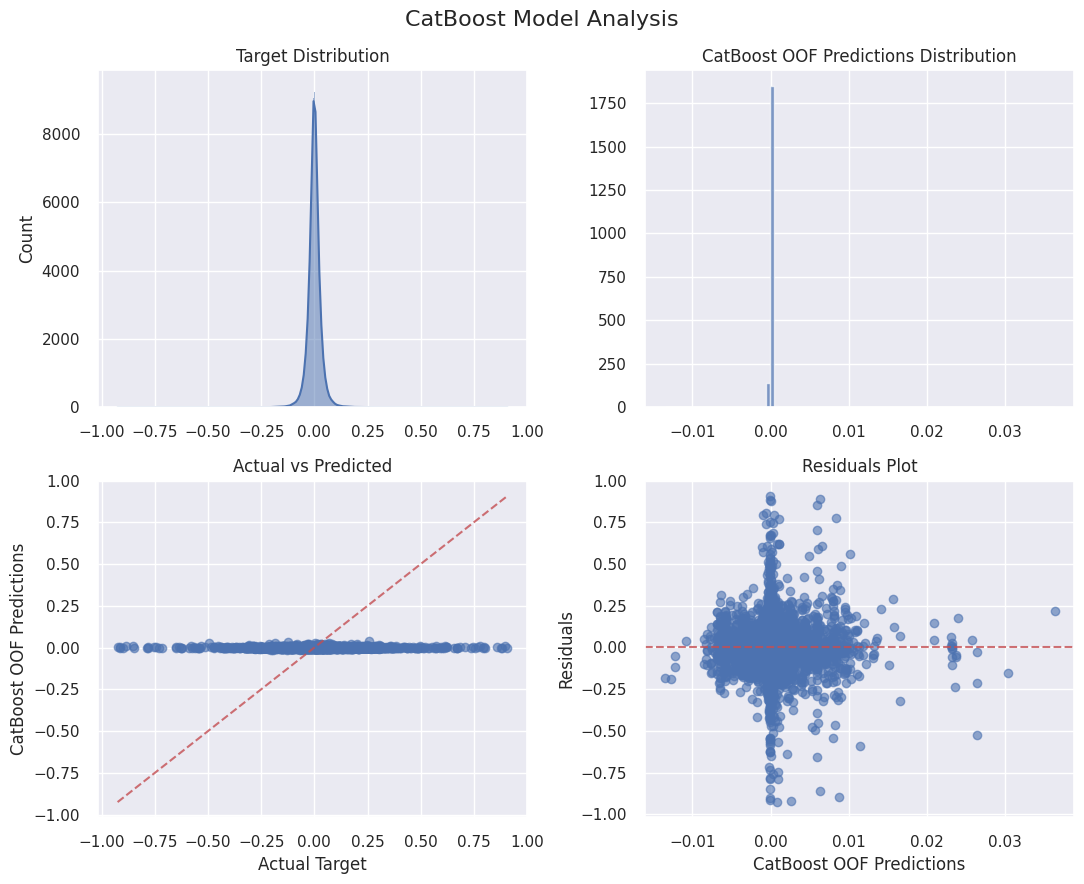


CatBoost OOF Metrics:
RMSE: 0.0318
MAE: 0.0212
R² Score: 0.0001


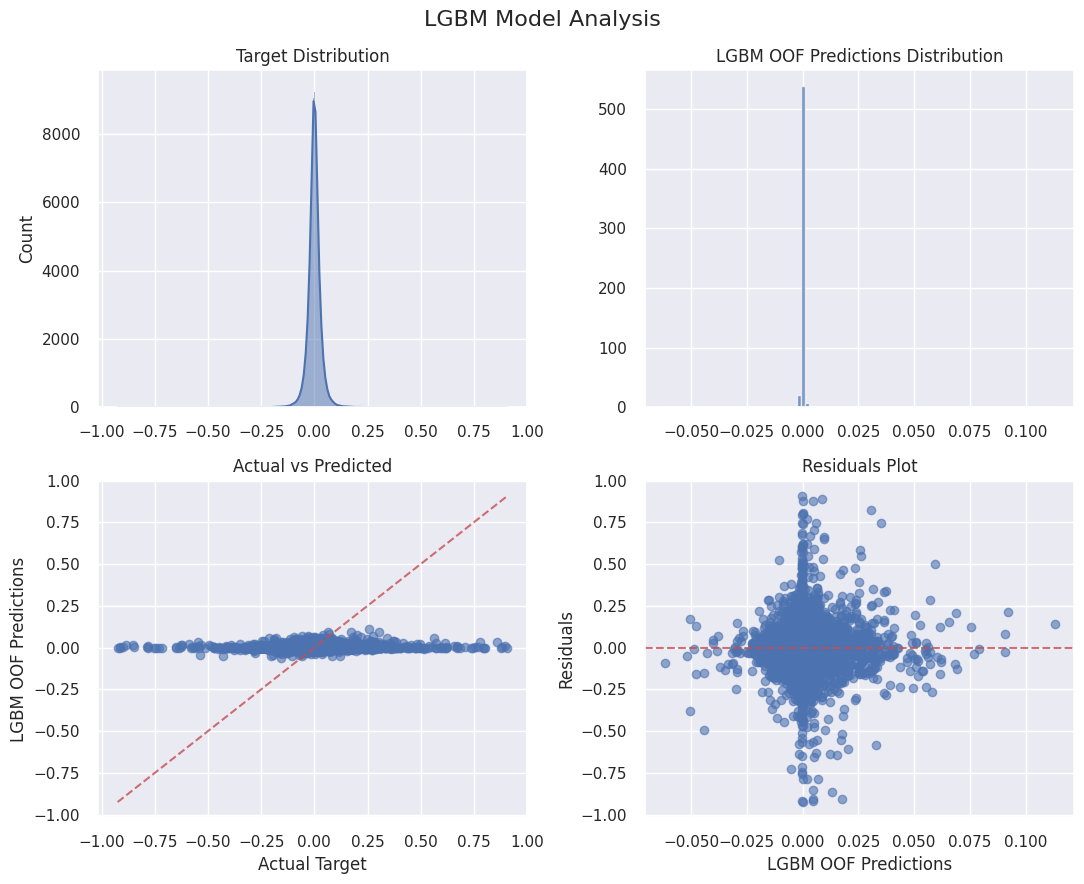


LGBM OOF Metrics:
RMSE: 0.0317
MAE: 0.0212
R² Score: 0.0015


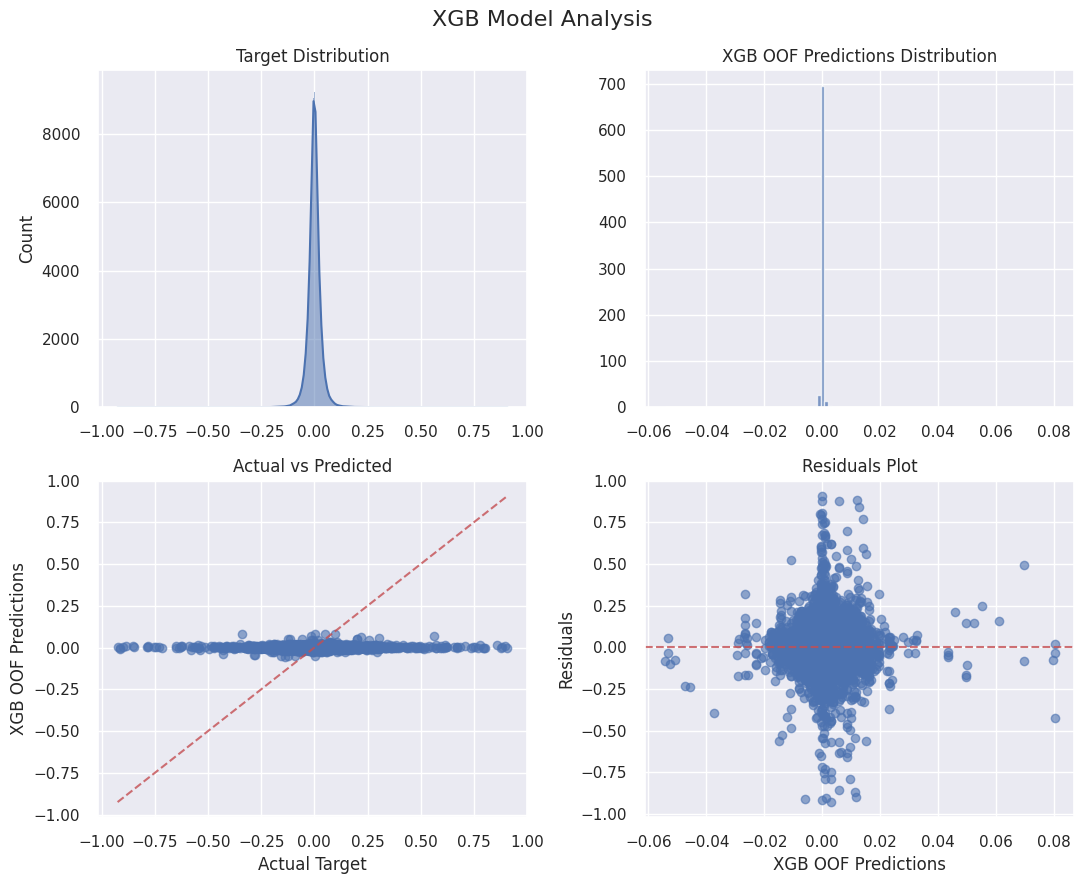


XGB OOF Metrics:
RMSE: 0.0318
MAE: 0.0212
R² Score: 0.0005
CPU times: user 37.3 s, sys: 203 ms, total: 37.5 s
Wall time: 36.1 s


In [45]:
%%time
model_analysis(Y_full, oof_cat, "CatBoost")
model_analysis(Y_full, oof_lgbm, "LGBM")
model_analysis(Y_full, oof_xgb, "XGB")